C:\Users\dylan\AppData\Local\Temp\ipykernel_18796\3869538861.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets.csv", parse_dates=['Periode'])


Validatie MAE: 3651.06


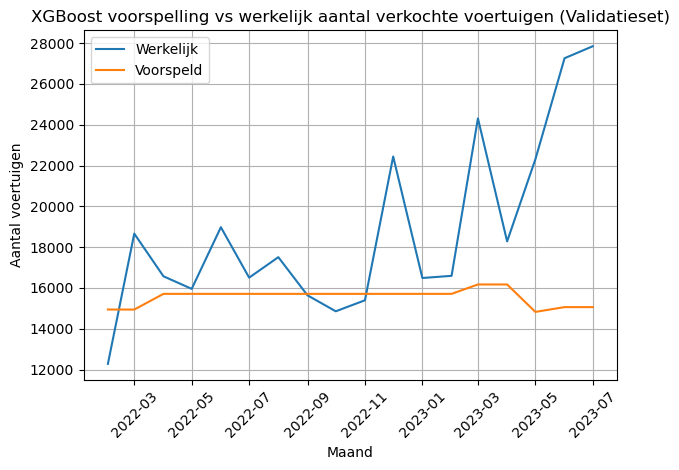

Gemiddelde foutmarge op validatieset: 16.57%


In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# === 1. Data inladen ===
df = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets.csv", parse_dates=['Periode'])
df.sort_values('Periode', inplace=True)
df.reset_index(drop=True, inplace=True)

# === 2. Lags toepassen ===
def apply_lags(df):
    df_lagged = df.copy()

    # Definieer kolommen
    sentiment_vars = ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid']
    fuel_vars = [col for col in df.columns if 'Benzine' in col or 'Diesel' in col]

    for col in sentiment_vars:
        df_lagged[f'{col}_lag2'] = df[col].shift(2)

    for col in fuel_vars:
        df_lagged[f'{col}_lag3'] = df[col].shift(3)

    return df_lagged

df_lagged = apply_lags(df)

# === 3. Alleen vertragingsfeatures gebruiken + target + periode
selected_cols = [col for col in df_lagged.columns if '_lag' in col or col in ['Periode', 'Totaal_verkochte_wegvoertuigen']]
df_clean = df_lagged[selected_cols].dropna().reset_index(drop=True)

# === 4. Chronologische splitsing (bv. 70/15/15) ===
n = len(df_clean)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

df_train = df_clean.iloc[:train_end]
df_val = df_clean.iloc[train_end:val_end]
df_test = df_clean.iloc[val_end:]

# === 5. Data splitsen ===
def get_X_y(df):
    X = df.drop(columns=['Periode', 'Totaal_verkochte_wegvoertuigen']).values
    y = df['Totaal_verkochte_wegvoertuigen'].values
    return X, y

trainX, trainy = get_X_y(df_train)
valX, valy = get_X_y(df_val)
testX, testy = get_X_y(df_test)

# === 6. XGBoost training en validatie ===
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(trainX, trainy)

# === 7. Evaluatie op validatieset ===
val_preds = model.predict(valX)
val_mae = mean_absolute_error(valy, val_preds)
print(f"Validatie MAE: {val_mae:.2f}")

# === 8. Plot voorspelling vs werkelijke waarden op validatieset ===
plt.plot(df_val['Periode'], valy, label='Werkelijk')
plt.plot(df_val['Periode'], val_preds, label='Voorspeld')
plt.title('XGBoost voorspelling vs werkelijk aantal verkochte voertuigen (Validatieset)')
plt.xlabel('Maand')
plt.ylabel('Aantal voertuigen')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 9. Foutmarge berekenen ===
val_errors = valy - val_preds


val_error_margin = (abs(val_errors) / valy) * 100


print("Gemiddelde foutmarge op validatieset: {:.2f}%".format(val_error_margin.mean()))
